# Kaggle: COVID Tweet Sentiment Classification - Alternative Approach

This is a solution for Kaggle project: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

This notebook takes different NLP approach based on observations in Covid-tweets-sentiment_method1 notebook.

Twitter is a place to express thoughts and ideas and spread news and information, thus makes it a great source to track trends worldwide. Through the collected tweets, we can evaluate people's attitude toward Covid and pandemic through the trending keywords and tags through time. The estimator can be useful for identifying inappropriate tweets and stop toxic propaganda or evaluating strategies to promote social distancing using trend words.

The task is to classify tweet sentiments in given tweets.

This notebook takes the approach of training multiple classifiers to identify tweet sentiment:
1. Sentiment classifier: combine extremely positive with positive and extremely negative with negative, and classify positive, negative, and neutral tweets.
2. Extremely positive classifier: from the predicted positive tweets, classify extreme tweets.
3. Extremely negative classifier: from the predicted negative tweets, classify extreme tweets.

Data has following columns:

|Column |Notes |
|:------|:-------|
UserName | User ID
ScreenName| User display name
Location | User location
TweetAt | Date
OriginalTweet | Tweet content
Sentiment | Extremely negative, Negative, Neutral, Positive, Extremely positive

## Load modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import json
import requests
import re
import string

pd.options.display.max_colwidth = 100

## Load data

In [2]:
train_df = pd.read_csv("Corona_NLP_train.csv", header=0, encoding='latin1')
test_df = pd.read_csv("Corona_NLP_test.csv", header=0, encoding='latin1')

## Clean data
### Handle useless column
Both UserName and ScreenName identify a user. We don't need both.

In [3]:
train_df.drop(columns="ScreenName", inplace=True)
test_df.drop(columns="ScreenName", inplace=True)
train_df.set_index("UserName", inplace=True)
test_df.set_index("UserName", inplace=True)

### Encode sentiment
Two encoders needed:
1. Sentiment encoder: encodes Extremely Negative with same label as Negative and Extremely Positive with same label as Positive
2. Extreme text encoder: encodes extreme tweets as 1 and regular tweets as 0

In [4]:
sentiment_encoder = {'Extremely Negative': 0,
                     'Negative': 0,
                     'Neutral': 1, 
                     'Positive': 2,
                     'Extremely Positive': 2}
           
train_df["Sentiment_encode"] = train_df.Sentiment.map(sentiment_encoder)
test_df["Sentiment_encode"] = test_df.Sentiment.map(sentiment_encoder)

In [5]:
extreme_txt_encoder = {'Extremely Negative': 1,
                      'Negative': 0,
                      'Neutral': 0,  
                      'Positive': 0,
                      'Extremely Positive': 1}

train_df["Extreme_txt_encode"] = train_df.Sentiment.map(extreme_txt_encoder)
test_df["Extreme_txt_encode"] = test_df.Sentiment.map(extreme_txt_encoder)

## Frequent Account Tags

Keep most frquent @:

In [6]:
tag_list = []
for tweet in train_df.index.values:
    tag_list += re.findall(r'@\w+', train_df.loc[tweet, "OriginalTweet"])
    
tag_df = pd.DataFrame(tag_list)
tag_sort = pd.DataFrame(tag_df.value_counts(ascending=False))

top_tags = [acct[0] for acct in tag_sort.index.values[:10]]

## Frequent Hashtags

Keep most frequent hashtags:

In [7]:
hash_list = []
for tweet in train_df.index.values:
    hash_list += re.findall(r'#\w+', train_df.loc[tweet, "OriginalTweet"])
    
hash_df = pd.DataFrame(hash_list)
hash_sort = pd.DataFrame(hash_df.value_counts(ascending=False))

top_hashtags = [tag[0] for tag in hash_sort.index.values[:30] 
                if "covid" not in tag[0].lower() and "corona" not in tag[0].lower()]

## Stop words

In [8]:
nltk.download('stopwords')
stop_words = list(set(nltk.corpus.stopwords.words('english')))
stop_words += ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "l", "m", "n", "o", "p", "q", "r", 
               "s", "t", "u", "v", "w", "x", "y", "z"]
stop_words += ["in", "on", "at", "via", "due", "one", "two", "etc", "per"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Examine tokens
After one round of training, examine and normalize tokens. 

1. Stemming is the process of eliminating affixes (suffixed, prefixes, infixes, circumfixes) from a word in order to obtain a word stem.
    - Example: running → run
2. Lemmatization is related to stemming, differing in that lemmatization is able to capture canonical forms based on a word's lemma.
    - Example: better → good

## Stemming

In [9]:
stemming_dict = {"buying":"buy", "bought":"buy", "working":"work", "worked":"work", "shopping":"shop", "shopped":"shop",
                 "shops":"shop", "days":"day", "weeks":"week", "masks":"mask", "got":"get", "gets":"get", 
                 "supermarkets":"supermarket", "says":"say", "saying":"say", "said":"say", "getting":"get", "gets":"get", 
                 "got":"get", "making":"make", "made":"make", "services":"service", "hours":"hour", "years":"year", 
                 "increases":"increase", "increased":"increase", "markets":"market", "close":"closed", "needs":"need",
                 "needed":"need", "hands":"hand", "stores":"store", "employees":"employee", "workers":"worker", 
                 "staffs":"staff", "businesses":"business", "companies":"company", "consumers":"consumer", 
                 "customers":"customer", "products":"product", "going":"go", "went":"go"}

## Lemmatization

In [10]:
lemmatization_dict = {"shop":"store", "supermarket":"market", "much":"many", "employee":"worker", "staff":"worker", 
                      "global":"world", "company":"business", "consumer":"customer", "house":"home", "grocery":"goods",
                      "products":"goods", "toilet":"toiletpaper", "paper":"toiletpaper"}

## Location dictionary

In [11]:
# Below files are used for data cleaning - Retrieving countries with help of city codes/state codes...(optional)
states = json.loads(requests.get("https://raw.githubusercontent.com/praneshsaminathan/country-state-city/master/states.json").text)
countries=json.loads(requests.get("https://raw.githubusercontent.com/praneshsaminathan/country-state-city/master/countries.json").text)
cities=json.loads(requests.get("https://raw.githubusercontent.com/praneshsaminathan/country-state-city/master/cities.json").text)
us_states_code=pd.read_csv('https://worldpopulationreview.com/static/states/abbr-name.csv',names=['state_code','state'])

states = states["states"]
countries = countries["countries"]
cities = cities["cities"]

In [12]:
world_dict = {}
    
for city in cities:
    state_id = int(re.findall(r'\d+', city["state_id"])[0])
    country_id = states[state_id-1]["country_id"]
    country_id = int(re.findall(r'\d+', country_id)[0])
    country_name = countries[country_id-1]["sortname"]
    world_dict[city["name"].lower()] = country_name.lower()
    
for state in states:
    country_id = int(re.findall(r'\d+', state["country_id"])[0])
    country_name = countries[country_id-1]["sortname"]
    world_dict[state["name"].lower()] = country_name.lower()
    
for country in countries:    
    world_dict[country["sortname"].lower()] = country["sortname"].lower()
    world_dict[country["name"].lower()] = country["sortname"].lower()
    
for index in us_states_code.index:
    state = us_states_code.loc[index]
    world_dict[state.state_code.lower()] = "us"
    world_dict[state.state.lower()] = "us"
    
world_dict["uk"] = "gb"
world_dict["ny"] = "us"
world_dict["nyc"] = "us"
world_dict["la"] = "us"
world_dict["sf"] = "us"
world_dict["bc"] = "ca"

## Clean sentence functions

In [13]:
def remove_link(sentence):
    return re.sub(r'http\S+', " ", sentence)

def remove_tag(sentence):
    keep_tag = []
    for tag in top_tags:
        keep_tag += re.findall(tag, sentence)        
    sentence = re.sub(r'@\S+', " ", sentence)    
    for tag in keep_tag:
        sentence += " " + tag        
    return sentence
    
def remove_hashtag(sentence):
    keep_tag = []
    for tag in top_hashtags:
        keep_tag += re.findall(tag, sentence)        
    sentence = re.sub(r'#\S+', " ", sentence)    
    for tag in keep_tag:
        sentence += " " + tag        
    return sentence
    
def remove_special_char(sentence):
    for special_ch in (string.punctuation + "0123456789" + "\r" + "\n"):
        sentence = sentence.replace(special_ch, " ")
    return sentence

def remove_non_english(sentence):
    clean_sentence = ""
    for word in sentence.split():
        clean_sentence += str(np.where(word.isalpha(), (word + " "), ""))
    return clean_sentence

def remove_stop_words(sentence):
    for word in ["covid", "corona", "virus"]:
        sentence = re.sub(word, " ", sentence)
    sentence = [word for word in sentence.split() if word not in stop_words]
    return " ".join(sentence)

def stemming_and_lemmatization(sentence):
    clean_sentence = []
    for word in sentence.split():
        if word in stemming_dict:
            word = stemming_dict[word]
        if word in lemmatization_dict:
            word = lemmatization_dict[word]
        clean_sentence.append(word)    
    return " ".join(clean_sentence)

def clean_sentence(sentence):
    sentence = remove_link(sentence)
    sentence = remove_tag(sentence)
    sentence = remove_hashtag(sentence)
    sentence = remove_special_char(sentence)
    sentence = remove_non_english(sentence)
    sentence = remove_stop_words(sentence)
    sentence = stemming_and_lemmatization(sentence)
    return sentence

## Clean OriginalTweet

In [14]:
def clean_original_tweet(df):
    clean_tweet = []
    loc_final_list = []

    for tweet in df.index.values:
        # clean location
        loc_final, loc_clean = "", ""
        if not pd.isnull(df.Location.loc[tweet]):
            loc_clean = df.Location.astype(str).loc[tweet].lower()
            loc_clean = clean_sentence(loc_clean)
            for sub in loc_clean.split():
                if sub in world_dict:
                    loc_final = world_dict[sub]
                    break
            # add to list if not empty
            if loc_final:
                loc_final_list.append(loc_final)

        # clean message
        msg = df.OriginalTweet.astype(str).loc[tweet].lower()
        msg = clean_sentence(msg)

        # combine location and message to one sentence
        clean_tweet.append(loc_final + " " + msg)

    df['CleanTweet'] = clean_tweet
    
    return clean_tweet, loc_final_list

In [15]:
clean_tweet, loc_final_list = clean_original_tweet(train_df)
dummy = clean_original_tweet(test_df)

In [16]:
train_df.head()

,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_encode,Extreme_txt_encode,CleanTweet
UserName,,,,,,,
3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://...,Neutral,1,0,gb
3800,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone n...,Positive,2,0,gb advice talk neighbours family exchange phone numbers create contact list phone numbers neighb...
3801,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-...",Positive,2,0,australia woolworths give elderly disabled dedicated store hour amid outbreak
3802,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL B...",Positive,2,0,food stock empty please panic enough food everyone take need stay calm stay safe
3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid...",Extremely Negative,0,1,ready go market outbreak paranoid food stock litteraly empty serious thing please panic causes ...


In [17]:
test_df.head()

,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_encode,Extreme_txt_encode,CleanTweet
UserName,,,,,,,
1,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-...",Extremely Negative,0,1,us trending new yorkers encounter empty market shelves pictured wegmans brooklyn sold online gro...
2,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack...",Positive,2,0,us find hand sanitizer fred meyer turned pack purell check concerns driving prices
3,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive,2,1,find protect loved ones
4,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after...,Negative,0,0,buy hits city anxious shoppers stock food amp medical supplies worker becomes st confirmed pati...
5,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News ...,Neutral,1,0,au week everyone buy baby milk powder next everyone buy toiletpaper toiletpaper toiletpaper


## Training set tweet length

Text(0.5, 1.0, 'Histogram of length of tweets')

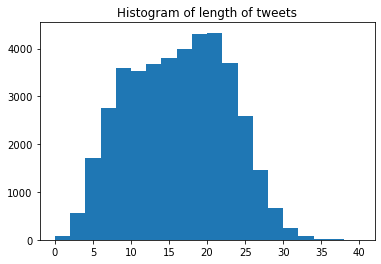

In [18]:
len_tweet = [len(tweet.split()) for tweet in train_df.CleanTweet]
plt.figure()
plt.hist(len_tweet, bins=20)
plt.title("Histogram of length of tweets")

## Test set tweet length

Text(0.5, 1.0, 'Histogram of length of tweets')

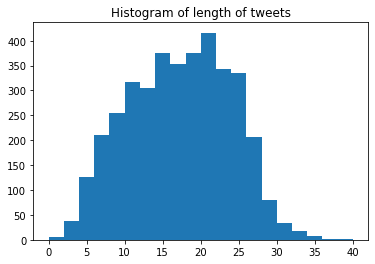

In [19]:
len_tweet = [len(tweet.split()) for tweet in test_df.CleanTweet]
plt.figure()
plt.hist(len_tweet, bins=20)
plt.title("Histogram of length of tweets")

## Sentiment Classifier
Classify if tweet is positive, neutral, or negative regardless if tweet uses extreme/drastic tones.

### Tokenize corpus

In [20]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df.CleanTweet.values)
vocab_size = len(tokenizer.word_index)
print(vocab_size)

max_len = 25

sequences = tokenizer.texts_to_sequences(train_df.CleanTweet.values)
train_corpus = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

sequences = tokenizer.texts_to_sequences(test_df.CleanTweet.values)
test_corpus = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

32223


In [21]:
train_target = train_df.Sentiment_encode.values
test_target = test_df.Sentiment_encode.values
target_len = len(set(sentiment_encoder.values()))

In [22]:
train_corpus.shape, train_target.shape, test_corpus.shape, test_target.shape, target_len

((41157, 25), (41157,), (3798, 25), (3798,), 3)

([<matplotlib.axis.XTick at 0x2023e8633c8>,
 [Text(0.0, 0, 'Negative'),
  Text(0.2, 0, ''),
  Text(0.4, 0, ''),
  Text(0.6, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, 'Neutral'),
  Text(1.2, 0, ''),
  Text(1.4, 0, ''),
  Text(1.6, 0, ''),
  Text(1.8, 0, ''),
  Text(2.0, 0, 'Positive')])

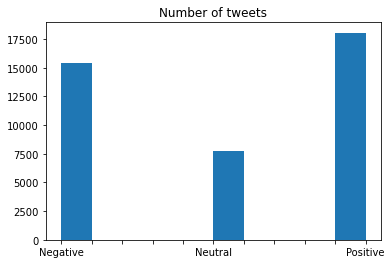

In [23]:
plt.hist(train_target)
plt.title("Number of tweets")
plt.xticks([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ], 
           ["Negative", "", "", "", "", "Neutral", "", "", "", "", "Positive"])

### Modeling

In [26]:
embd_dim = 32
batch = 32
epoch = 3

sentiment_classifier = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embd_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embd_dim*8)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(target_len, activation=tf.nn.sigmoid)
])
sentiment_classifier.compile(optimizer='adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
sentiment_classifier.fit(train_corpus, train_target, epochs=epoch, batch_size=batch, validation_data=(test_corpus, test_target))

Train on 41157 samples, validate on 3798 samples
Epoch 1/3
41157/41157 [==============================] - 39s 945us/sample - loss: 0.6548 - accuracy: 0.7107 - val_loss: 0.4705 - val_accuracy: 0.8294
Epoch 2/3
41157/41157 [==============================] - 33s 798us/sample - loss: 0.3401 - accuracy: 0.8872 - val_loss: 0.4320 - val_accuracy: 0.8478
Epoch 3/3
41157/41157 [==============================] - 34s 818us/sample - loss: 0.2642 - accuracy: 0.9150 - val_loss: 0.4547 - val_accuracy: 0.8444


### Predict

In [27]:
test_predict = np.argmax(sentiment_classifier.predict(test_corpus), axis=1)
test_df['Sentiment_pred'] = test_predict
test_df.head()

,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_encode,Extreme_txt_encode,CleanTweet,Sentiment_pred
UserName,,,,,,,,
1,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-...",Extremely Negative,0,1,us trending new yorkers encounter empty market shelves pictured wegmans brooklyn sold online gro...,0
2,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack...",Positive,2,0,us find hand sanitizer fred meyer turned pack purell check concerns driving prices,2
3,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive,2,1,find protect loved ones,2
4,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after...,Negative,0,0,buy hits city anxious shoppers stock food amp medical supplies worker becomes st confirmed pati...,0
5,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News ...,Neutral,1,0,au week everyone buy baby milk powder next everyone buy toiletpaper toiletpaper toiletpaper,1


After we classified the sentiment of tweets in test set, next is to classify the extreme tweets. We'll keep the possible neutral tweet corpus as is.

## Extreme Text Classifier

## Extremely positive  tweet classifier

Traing classifier to identify extreme tweets in the previously classified positive tweets.

### Tokenize corpus

Tokenize Extremely Positive and Positive corpus in training set and transform test set.

In [28]:
train = train_df[train_df.Sentiment_encode==2]
test = test_df[test_df.Sentiment_pred==2]

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train.CleanTweet.values)
vocab_size = len(tokenizer.word_index)
print(vocab_size)

max_len = 25

sequences = tokenizer.texts_to_sequences(train.CleanTweet.values)
train_corpus = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

sequences = tokenizer.texts_to_sequences(test.CleanTweet.values)
test_corpus = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

21450


In [29]:
train_target = train.Extreme_txt_encode.values
test_target = test.Extreme_txt_encode.values
target_len = len(set(extreme_txt_encoder.values()))

In [30]:
train_target.shape, train_corpus.shape, test_target.shape, test_corpus.shape

((18046,), (18046, 25), (1708,), (1708, 25))

### Modeling

In [31]:
embd_dim = 32
batch = 32
epoch = 3

extreme_pos_classifier = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embd_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embd_dim*8)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
extreme_pos_classifier.compile(optimizer='adam', loss=tf.losses.binary_crossentropy, metrics=['accuracy'])
extreme_pos_classifier.fit(train_corpus, train_target, epochs=epoch, batch_size=batch, validation_data=(test_corpus, test_target))

Train on 18046 samples, validate on 1708 samples
Epoch 1/3
18046/18046 [==============================] - 17s 964us/sample - loss: 0.5441 - accuracy: 0.7332 - val_loss: 0.4766 - val_accuracy: 0.7799
Epoch 2/3
18046/18046 [==============================] - 13s 744us/sample - loss: 0.3619 - accuracy: 0.8496 - val_loss: 0.4858 - val_accuracy: 0.7728
Epoch 3/3
18046/18046 [==============================] - 14s 753us/sample - loss: 0.2603 - accuracy: 0.8983 - val_loss: 0.5462 - val_accuracy: 0.7711


### Predict

Use trained model to classify the extreme tweets in previously classified positive tweets.

In [32]:
test_predict = [int(np.where(pred>0.5, 1, 0)) for pred in extreme_pos_classifier.predict(test_corpus)]
test_df["Extreme_pos_pred"]=None
test_df.loc[test_df[test_df.Sentiment_pred==2].index, "Extreme_pos_pred"] = test_predict
test_df.head()

,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_encode,Extreme_txt_encode,CleanTweet,Sentiment_pred,Extreme_pos_pred
UserName,,,,,,,,,
1,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-...",Extremely Negative,0,1,us trending new yorkers encounter empty market shelves pictured wegmans brooklyn sold online gro...,0,None
2,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack...",Positive,2,0,us find hand sanitizer fred meyer turned pack purell check concerns driving prices,2,0
3,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive,2,1,find protect loved ones,2,1
4,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after...,Negative,0,0,buy hits city anxious shoppers stock food amp medical supplies worker becomes st confirmed pati...,0,None
5,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News ...,Neutral,1,0,au week everyone buy baby milk powder next everyone buy toiletpaper toiletpaper toiletpaper,1,None


## Extremely negative tweet classifier

Traing classifier to identify extreme tweets in the previously classified negative tweets.

### Tokenize corpus

Tokenize Extremely Negative and Negative corpus in training set and transform test set.

In [33]:
train = train_df[train_df.Sentiment_encode==0]
test = test_df[test_df.Sentiment_pred==0]

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train.CleanTweet.values)
vocab_size = len(tokenizer.word_index)
print(vocab_size)

max_len = 25

sequences = tokenizer.texts_to_sequences(train.CleanTweet.values)
train_corpus = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

sequences = tokenizer.texts_to_sequences(test.CleanTweet.values)
test_corpus = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

20042


In [34]:
train_target = train.Extreme_txt_encode.values
test_target = test.Extreme_txt_encode.values
target_len = len(set(extreme_txt_encoder.values()))

In [35]:
train_target.shape, train_corpus.shape, test_target.shape, test_corpus.shape

((15398,), (15398, 25), (1543,), (1543, 25))

### Modeling

In [36]:
embd_dim = 32
batch = 32
epoch = 3

extreme_neg_classifier = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embd_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(embd_dim*8)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
extreme_neg_classifier.compile(optimizer='adam', loss=tf.losses.binary_crossentropy, metrics=['accuracy'])
extreme_neg_classifier.fit(train_corpus, train_target, epochs=epoch, batch_size=batch, validation_data=(test_corpus, test_target))

Train on 15398 samples, validate on 1543 samples
Epoch 1/3
15398/15398 [==============================] - 15s 1ms/sample - loss: 0.5685 - accuracy: 0.7055 - val_loss: 0.5856 - val_accuracy: 0.7226
Epoch 2/3
15398/15398 [==============================] - 11s 743us/sample - loss: 0.3691 - accuracy: 0.8402 - val_loss: 0.5430 - val_accuracy: 0.7362
Epoch 3/3
15398/15398 [==============================] - 12s 747us/sample - loss: 0.2459 - accuracy: 0.9009 - val_loss: 0.6080 - val_accuracy: 0.7447


### Predict

Use trained model to classify the extreme tweets in previously classified negative tweets.

In [37]:
test_predict = [int(np.where(pred>0.5, 1, 0)) for pred in extreme_neg_classifier.predict(test_corpus)]
test_df["Extreme_neg_pred"]=None
test_df.loc[test_df[test_df.Sentiment_pred==0].index, "Extreme_neg_pred"] = test_predict
test_df.head()

,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_encode,Extreme_txt_encode,CleanTweet,Sentiment_pred,Extreme_pos_pred,Extreme_neg_pred
UserName,,,,,,,,,,
1,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-...",Extremely Negative,0,1,us trending new yorkers encounter empty market shelves pictured wegmans brooklyn sold online gro...,0,None,0
2,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack...",Positive,2,0,us find hand sanitizer fred meyer turned pack purell check concerns driving prices,2,0,None
3,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive,2,1,find protect loved ones,2,1,None
4,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after...,Negative,0,0,buy hits city anxious shoppers stock food amp medical supplies worker becomes st confirmed pati...,0,None,0
5,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News ...,Neutral,1,0,au week everyone buy baby milk powder next everyone buy toiletpaper toiletpaper toiletpaper,1,None,None


## Evaluation
Find the total misclassified rate and misclassified rate of each model.

In [39]:
prediction = []
for user in test_df.index.values:
    sentiment = ""
    if test_df.loc[user, "Extreme_pos_pred"] == 1 or \
       test_df.loc[user, "Extreme_neg_pred"] == 1:
        sentiment += "Extremely "
    if test_df.loc[user, "Sentiment_pred"] == 0:
        sentiment += "Negative"
    elif test_df.loc[user, "Sentiment_pred"] == 1:
        sentiment += "Neutral"
    elif test_df.loc[user, "Sentiment_pred"] == 2:
        sentiment += "Positive"
    prediction.append(sentiment)
        
test_df["Prediction"] = prediction
test_df["Misclassified"] = (test_df.Sentiment!=test_df.Prediction).astype(int)
test_df[["Sentiment", "Prediction", "Misclassified"]].head(10)

,Sentiment,Prediction,Misclassified
UserName,,,
1,Extremely Negative,Negative,1
2,Positive,Positive,0
3,Extremely Positive,Extremely Positive,0
4,Negative,Negative,0
5,Neutral,Neutral,0
6,Neutral,Neutral,0
7,Positive,Positive,0
8,Neutral,Negative,1
9,Extremely Negative,Extremely Negative,0


In [40]:
test_df.groupby(["Sentiment"]).Misclassified.describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
Extremely Negative,592.0,0.380068,0.485814,0.0,0.0,0.0,1.0,1.0
Extremely Positive,599.0,0.347245,0.476492,0.0,0.0,0.0,1.0,1.0
Negative,1041.0,0.409222,0.491927,0.0,0.0,0.0,1.0,1.0
Neutral,619.0,0.234249,0.423871,0.0,0.0,0.0,0.0,1.0
Positive,947.0,0.287223,0.452706,0.0,0.0,0.0,1.0,1.0


In [45]:
# Count the misclassified
test_df.pivot_table(index="Prediction", columns="Sentiment", values="Misclassified", aggfunc=np.sum)

Sentiment,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
Prediction,,,,,
Extremely Negative,0.0,7.0,164.0,1.0,21.0
Extremely Positive,4.0,0.0,31.0,9.0,142.0
Negative,193.0,15.0,0.0,72.0,88.0
Neutral,5.0,NaN,47.0,0.0,21.0
Positive,23.0,186.0,184.0,63.0,0.0


In [46]:
# Rate of misclassification
total = test_df.groupby(['Sentiment']).size().to_list()
(test_df.pivot_table(index="Prediction", columns="Sentiment", values="Misclassified", aggfunc=np.sum)/total)*100

Sentiment,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
Prediction,,,,,
Extremely Negative,0.000000,1.168614,15.754083,0.161551,2.217529
Extremely Positive,0.675676,0.000000,2.977906,1.453958,14.994720
Negative,32.601351,2.504174,0.000000,11.631664,9.292503
Neutral,0.844595,NaN,4.514890,0.000000,2.217529
Positive,3.885135,31.051753,17.675312,10.177706,0.000000


## Evaluate performance
- The overall accuracy: 66% accuracy
    - 1276 misclassifications out of 3798 samples
    - Neutral (77%) > Positive (71%) > Extremely Negative (65%) > Extremely Negative (62%) > Negative (59%)
- Sentiment classifier misclassified:
    - 294 out of 1633 negative (Negative + Extremely Negative) tweets were misclassified as other sentiment
        - 82% accuracy
    - 152 out of 1546 positive (Positive + Extremely Positive) tweets were misclassified as other sentiment
        - 90% accuracy
    - 145 out of 619 neutral tweets were misclassified as other sentiment
        - 77% accuracy

- Extremely negative tweet classifier misclassified:
    - 164 negative misclassified as extremely negative and 193 extremely negative as negative
        - 357 misclassifications out of 1633 negative tweets
        - 78% accuracy

- Extremely positive tweet classifier misclassified:
    - 142 positive misclassified as extremely positive and 186 extremely positive as positive
        - 328 misclassifications out of 1546 positive tweets
        - 79% accuracy

## Conclusion
In general, similar observation from first notebook can still be observed here. And applying multiple classified specified with different focus has not helped improving accuracy.
1. Independent classifier accuracy v.s. overall accuracy
Each classifier independently has better performance, especially the sentiment classifier, but the overall accuracy is worst than first approach since the error cumulates through two predictions back to back. 
2. Weakness with extreme tweets
The result shows that classifier is still unable to fully identify extreme sentiment v.s. normal sentiment even with a dedicated classifier just to detect this feature, which was meant to fix this weakness. It's good idea to review and filter the OriginalTweets and see what keywords or criteria make a tweet extremely positive or negative, then adjust data processing or modeling accordingly.
3. Sentiment classification
Regardless of extremeness in a tweet, the sentiment classifier by itself has good performance, which is expected since it's observed in the other notebook with other approach that model is weak at detecting extreme vs normal sentiment but relatively good at detecting positive, neutral, and negative. Thus it's expected to have better accuracy if intensity of sentiment is not part of consideration.

### Improvements:
- Make use of date
- Review tweet contents and tokens to clean up text more
- Expand stopwords, stemming dictionary, and lemmatization dictionary
- Clean up tweets and remove noise so that critical keywords stand out more